In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [2]:
dhas = pd.read_csv('fueld_dhas.csv')
summed_dhas = dhas.groupby(['sample_id', 'COMPONENT']).sum().reset_index()

mol_props = pd.read_csv('compound_properties.csv')

In [3]:
mol_percent = summed_dhas.pivot(index='COMPONENT', columns='sample_id', values='%MOL').fillna(0.)

mol_props['sooting_index'] = (mol_props['YSI'] * mol_props['HoV']) / mol_props['Vp']
mol_sooting_index = mol_props.set_index('COMPONENT').reindex(mol_percent.index)['sooting_index']
percent_coverage = mol_percent.T.dot(~mol_sooting_index.isna())
percent_coverage

sample_id
42791    93.436
42909    95.150
42910    95.485
42911    94.933
42912    95.451
42913    94.826
42914    95.119
42915    94.807
42916    95.111
42917    95.981
42918    94.478
42919    94.701
dtype: float64

In [4]:
sooting_index = (mol_percent.T.dot(mol_sooting_index.fillna(0.)) /
                 mol_percent.T.dot(~mol_sooting_index.isna()) * 100)

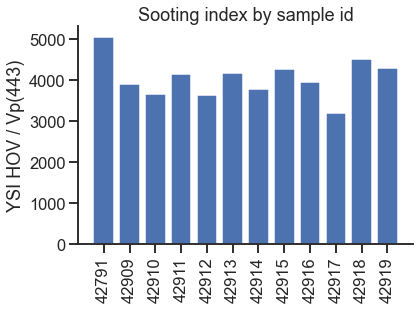

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(np.arange(len(sooting_index)), sooting_index)
ax.set_xticks(np.arange(len(sooting_index)))
ax.set_xticklabels(sooting_index.index, rotation=90)
ax.set_ylabel('YSI HOV / Vp(443)')

plt.title('Sooting index by sample id')
sns.despine()

In [6]:
fuel_data = pd.read_csv('fueld_properties.csv', index_col=0)

In [7]:
fuel_props = pd.concat([fuel_data.loc['T70%:'], fuel_data.loc['Specific Gravity@ 60°F:']], 1)
fuel_props['T70%:'] = (fuel_props['T70%:'] - 32) * (5/9)

fuel_index = fuel_props.index.str.extract('^(.*):')[0].astype(int)
fuel_index.name = 'sample_id'
fuel_props.index = fuel_index
fuel_props['sooting_index'] = sooting_index.reindex(fuel_props.index)

fuel_props_z = fuel_props.transform(lambda x: (x - x.mean()) / x.std())

In [8]:
fuel_props

,T70%:,Specific Gravity@ 60°F:,sooting_index
sample_id,,,
42791,125.055556,0.7397,5065.362474
42909,122.722222,0.7445,3903.141878
42910,121.222222,0.7444,3649.303182
42911,121.722222,0.7445,4148.409215
42912,118.888889,0.7468,3644.130600
42913,119.833333,0.7480,4162.904409
42914,98.000000,0.7522,3781.773533
42915,108.388889,0.7491,4279.467514
42916,111.722222,0.7416,3957.503675


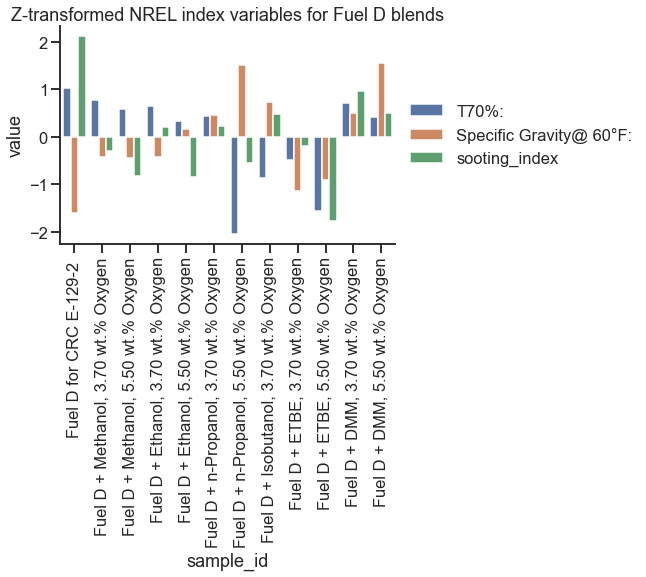

In [23]:
sns.barplot(y='value', x='sample_id', data=fuel_props_z.reset_index().melt(
    id_vars=['sample_id']), hue='variable')

ax = plt.gca()
ax.set_xticklabels(fuel_data.columns.str.extract(': (.*)')[0], rotation=90)
plt.legend(loc='center left', bbox_to_anchor=(1., .5))

plt.title('Z-transformed NREL index variables for Fuel D blends')
sns.despine()

Text(0.5, 0, 'Normalized, Log-Transformed\nEPAct Bag 1 PM Emissions')

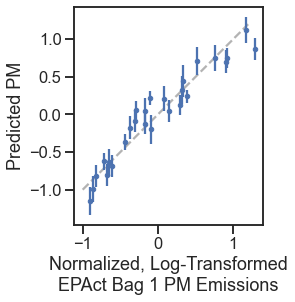

In [10]:
epact = pd.read_csv('epa.csv', index_col=0)

import statsmodels.api as sm
epa_data = sm.add_constant(epact[['Density', 'T70', 'YSI HOV VP-1']])
mod = sm.OLS(epact.y, epa_data)
res = mod.fit()
res.summary()

a = res.get_prediction()

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')

ax.errorbar(epact.y, a.predicted_mean, 
             yerr=np.abs(a.conf_int().T - np.atleast_2d(a.predicted_mean)),
             marker='.', ls='')

ax.plot([-1, 1.2], [-1, 1.2], ls='--', zorder=0, color='.7')
ax.set_ylabel('Predicted PM')
ax.set_xlabel('Normalized, Log-Transformed\nEPAct Bag 1 PM Emissions')

# plt.savefig('figs/epa_pred.pdf', bbox_inches='tight')

In [11]:
new_fuels_x = fuel_props[['Specific Gravity@ 60°F:', 'T70%:', 'sooting_index']]
new_fuels_x.columns = ['Density', 'T70', 'YSI HOV VP-1']
new_fuels_x = sm.add_constant(new_fuels_x)

predicted = res.get_prediction(new_fuels_x)

new_fuels_x

,const,Density,T70,YSI HOV VP-1
sample_id,,,,
42791,1.0,0.7397,125.055556,5065.362474
42909,1.0,0.7445,122.722222,3903.141878
42910,1.0,0.7444,121.222222,3649.303182
42911,1.0,0.7445,121.722222,4148.409215
42912,1.0,0.7468,118.888889,3644.130600
42913,1.0,0.7480,119.833333,4162.904409
42914,1.0,0.7522,98.000000,3781.773533
42915,1.0,0.7491,108.388889,4279.467514
42916,1.0,0.7416,111.722222,3957.503675


In [12]:
fuelc = pd.read_csv('fuel_c_values.csv')

In [13]:
pred_c = res.get_prediction(fuelc.iloc[:, :4])

In [14]:
fuelc

,const,Density,T70,YSI HOV VP-1,Fuel Name
0,1.0,0.7393,114.6,2667.769010,EPA Cert
1,1.0,0.7460,117.1,1666.815488,Fuel C E15
2,1.0,0.7432,118.3,1910.134725,Fuel C E10
3,1.0,0.7400,115.0,1872.930931,Fuel C 19 MTBE
4,1.0,0.7489,106.7,1928.632553,Fuel C 16 Isobutanol
5,1.0,0.7386,120.7,2307.196262,Fuel C


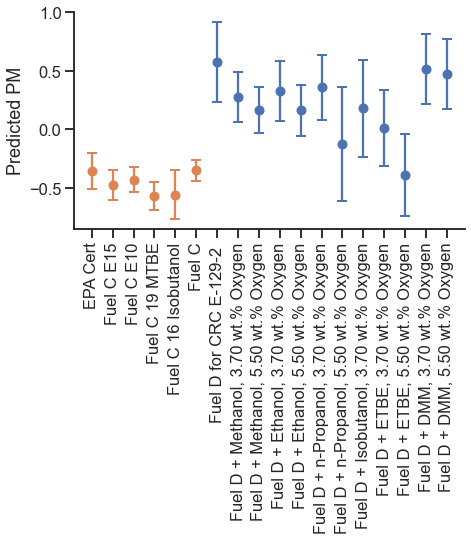

In [15]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)

ax.errorbar(len(fuelc) + np.arange(len(new_fuels_x)), predicted.predicted_mean, 
             yerr=np.abs(predicted.conf_int().T - np.atleast_2d(predicted.predicted_mean)),
             marker='o', ls='', capsize=5, capthick=2)

ax.errorbar(np.arange(len(fuelc)), pred_c.predicted_mean, 
             yerr=np.abs(pred_c.conf_int().T - np.atleast_2d(pred_c.predicted_mean)),
             marker='o', ls='', capsize=5, capthick=2)

ax.set_ylabel('Predicted PM')
ax.set_xticks(np.arange(len(fuelc) + len(new_fuels_x)))
_ = ax.set_xticklabels(pd.concat([fuelc['Fuel Name'], fuel_data.columns.str.extract(': (.*)')[0]]), rotation=90)

sns.despine()
# plt.savefig('figs/predicted_term.pdf', bbox_inches='tight')

In [16]:
fuel_data.columns.str.extract(': (.*)')[0]

0                   Fuel D for CRC E-129-2 
1       Fuel D + Methanol, 3.70 wt.% Oxygen
2       Fuel D + Methanol, 5.50 wt.% Oxygen
3        Fuel D + Ethanol, 3.70 wt.% Oxygen
4        Fuel D + Ethanol, 5.50 wt.% Oxygen
5     Fuel D + n-Propanol, 3.70 wt.% Oxygen
6     Fuel D + n-Propanol, 5.50 wt.% Oxygen
7     Fuel D + Isobutanol, 3.70 wt.% Oxygen
8           Fuel D + ETBE, 3.70 wt.% Oxygen
9           Fuel D + ETBE, 5.50 wt.% Oxygen
10           Fuel D + DMM, 3.70 wt.% Oxygen
11           Fuel D + DMM, 5.50 wt.% Oxygen
Name: 0, dtype: object

In [17]:
fuel_data.index

Index(['Specific Gravity@ 60°F:', 'Density @15.56°C:', 'API Gravity @ 60°F:',
       'Research Octane Number:', 'Motor Octane Number:', 'Octane Rating:',
       'Sensitivity:', 'Aromatic Content:', 'Olefin Content:',
       'Saturate Content:', 'C6 Aromatic Content:', 'C10+ Aromatic Content:',
       'PMI Gage:', 'RVP @ 100°F:', 'Sulfur Content:', 'Distillations:',
       'Initial BP:', 'T5%:', 'T10%:', 'T20%:', 'T30%:', 'T40%:', 'T50%:',
       'T60%:', 'T70%:', 'T80%:', 'T90%:', 'T95%:', 'Final BP:', 'Recovery:',
       'Residue:', 'Loss:', 'Drivability Index:', 'Oxygenate Content:',
       'Methanol Content:', 'Ethanol Content:', 'n-Propanol Content:',
       'Isobutanol Content:', 'ETBE Content:', 'DMM Content:',
       'Oxygen Content:', 'Carbon Content:', 'Hydrogen Content:', 'C/H Ratio:',
       'H/C Ratio:', 'O/C Ratio:', 'Net Heat of Combustion:',
       'Existent Gum (Washed):', 'Unwashed Gum:'],
      dtype='object', name='Property:')

In [18]:
new_fuels_x['Fuel Name'] = fuel_data.columns.str.extract(': (.*)')[0].values
combined = fuelc.append(new_fuels_x).reset_index(drop=True)
combined['color'] = [sns.color_palette()[1] if i < 6 else sns.color_palette()[0] for i in combined.index]

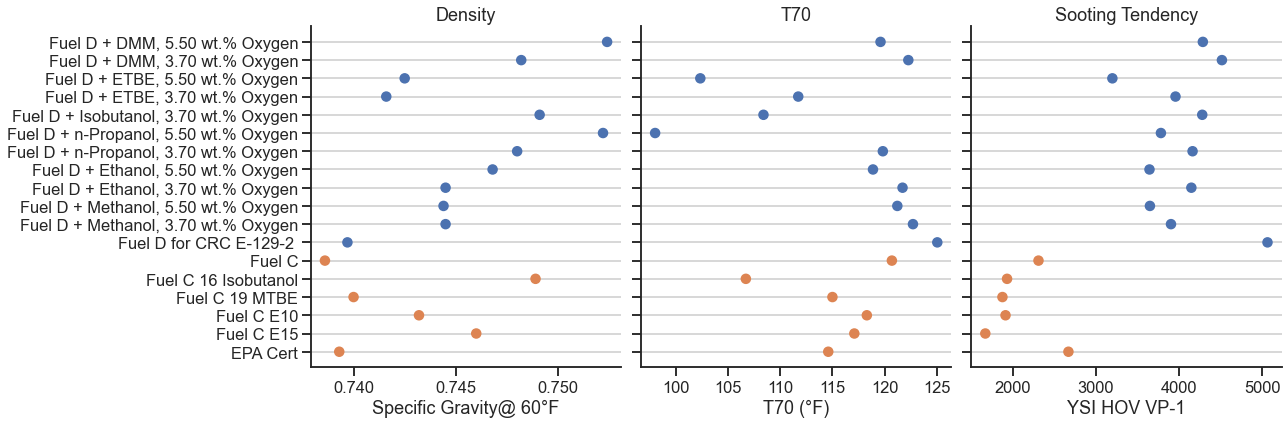

In [19]:
fig, axs = plt.subplots(ncols=3, figsize=(18, 6), sharey=True)

axs[0].scatter(combined.Density, combined.index,  marker='o', c=combined.color)
axs[1].scatter(combined.T70, combined.index,  marker='o', c=combined.color)
axs[2].scatter(combined['YSI HOV VP-1'], combined.index, marker='o', c=combined.color)

axs[0].set_title('Density')
axs[1].set_title('T70')
axs[2].set_title('Sooting Tendency')

axs[0].set_xlabel('Specific Gravity@ 60°F')
axs[1].set_xlabel('T70 (°F)')
axs[2].set_xlabel('YSI HOV VP-1')

axs[0].grid(axis='y')
axs[1].grid(axis='y')
axs[2].grid(axis='y')


axs[0].set_yticks(combined.index)
_ = axs[0].set_yticklabels(combined['Fuel Name'])
sns.despine()
plt.tight_layout()
# plt.savefig('figs/individual_parameters.pdf')

In [20]:
distillation_curves = (fuel_data.iloc[16:29] - 32) * (5/9)
distillation_curves.index = [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 100]
distillation_curves

,42791: Fuel D for CRC E-129-2,"42909: Fuel D + Methanol, 3.70 wt.% Oxygen","42910: Fuel D + Methanol, 5.50 wt.% Oxygen","42911: Fuel D + Ethanol, 3.70 wt.% Oxygen","42912: Fuel D + Ethanol, 5.50 wt.% Oxygen","42913: Fuel D + n-Propanol, 3.70 wt.% Oxygen","42914: Fuel D + n-Propanol, 5.50 wt.% Oxygen","42915: Fuel D + Isobutanol, 3.70 wt.% Oxygen","42916: Fuel D + ETBE, 3.70 wt.% Oxygen","42917: Fuel D + ETBE, 5.50 wt.% Oxygen","42918: Fuel D + DMM, 3.70 wt.% Oxygen","42919: Fuel D + DMM, 5.50 wt.% Oxygen"
0,33.333333,36.333333,37.000000,36.833333,37.055556,36.222222,36.611111,33.944444,36.388889,37.444444,31.555556,31.111111
5,53.000000,46.111111,46.055556,52.444444,53.333333,57.111111,58.500000,57.500000,57.833333,59.055556,46.444444,43.055556
10,62.277778,48.777778,48.888889,56.666667,57.222222,64.222222,65.666667,66.666667,64.777778,65.166667,53.666667,50.277778
20,75.388889,52.722222,53.055556,62.777778,63.055556,73.555556,74.944444,78.555556,73.611111,72.333333,64.888889,60.055556
30,87.888889,68.777778,56.111111,67.222222,67.555556,80.444444,81.500000,87.166667,80.888889,77.888889,77.500000,71.555556
40,98.555556,95.333333,84.444444,76.277778,70.555556,85.111111,85.611111,92.944444,87.166667,82.611111,91.611111,86.222222
50,106.722222,104.666667,102.500000,102.000000,77.777778,89.055556,88.166667,96.777778,93.111111,87.055556,103.111111,100.055556
60,114.611111,112.944444,110.777778,111.500000,108.388889,99.944444,90.611111,100.722222,100.555556,92.777778,111.888889,109.833333
70,125.055556,122.722222,121.222222,121.722222,118.888889,119.833333,98.000000,108.388889,111.722222,102.333333,122.277778,119.611111
80,145.277778,142.388889,139.666667,141.333333,137.444444,139.666667,134.888889,136.000000,131.444444,118.722222,141.611111,138.666667


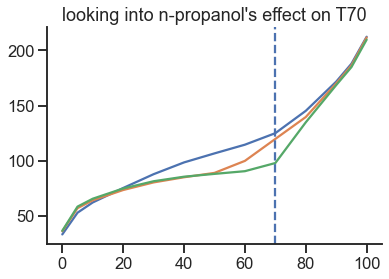

In [21]:
_ = plt.plot(distillation_curves[['42791: Fuel D for CRC E-129-2 ',
                                  '42913: Fuel D + n-Propanol, 3.70 wt.% Oxygen', 
                                  '42914: Fuel D + n-Propanol, 5.50 wt.% Oxygen']])

ax = plt.gca()
# ax.set_xticks(np.arange(distillation_curves.shape[0]))
# ax.set_xticklabels(distillation_curves.index.str.strip(':'), rotation=90)
plt.title("looking into n-propanol's effect on T70")
ax.axvline(70, ls='--')
sns.despine()